In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import googlemaps
import geopy
import geopandas
import requests

In [2]:
GOOGLE_API_KEY = '' # copy API key from GCP credentials

In [3]:
orders_full = pd.read_csv('../Forecasting/data/rologolf_orders.csv', header = 0, sep=',')
orders_full.describe()

,Subtotal,Shipping,Taxes,Total,Discount Amount,Lineitem quantity,Lineitem price,Lineitem compare at price,Lineitem sku,Note Attributes,...,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number
count,403.000000,403.000000,403.000000,403.000000,403.000000,630.000000,630.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.300000e+01,0.0
mean,68.264069,7.278486,0.182010,75.724566,36.173747,1.050794,64.171190,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.618236e+10,NaN
std,46.619101,4.981776,1.412362,44.799425,47.354108,0.271528,14.638838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.092908e+09,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.690000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.226751e+10,NaN
25%,35.880000,0.000000,0.000000,49.220000,10.350000,1.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.416727e+10,NaN
50%,58.650000,9.460000,0.000000,69.000000,27.600000,1.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.647279e+10,NaN
75%,71.760000,10.380000,0.000000,86.010000,50.845000,1.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.787300e+10,NaN
max,483.000000,26.720000,16.140000,483.000000,483.000000,4.000000,69.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.949923e+10,NaN


In [132]:
cols = ['Name','Shipping Method','Created at','Shipping Street','Shipping Address1',
       'Shipping Address2','Shipping City','Shipping Zip','Shipping Province','Shipping Country']

orders = orders_full.dropna(axis='rows', subset=['Shipping Address1']).reset_index(drop=True)
orders = orders.drop(orders[orders['Fulfillment Status'] == 'unfulfilled'].index)
orders = orders[cols]

orders['Shipping Zip'] = orders['Shipping Zip'].str.replace("'","").str.replace(" ","")
orders['Full Address'] = orders['Shipping Address1'] + ', ' + orders['Shipping City'] + ' ' + \
    orders['Shipping Province'] + ' ' + orders['Shipping Country']
orders = orders.drop(['Shipping Street', 'Shipping Address1', 'Shipping Address2',
                      'Shipping City', 'Shipping Province', 'Shipping Country'], axis=1)

orders['datetime'] = orders['Created at'].apply(lambda st: st[:19])
orders['datetime'] = pd.to_datetime(orders['datetime'], errors='coerce')
orders['datetime'] = orders['datetime'] - timedelta(hours=4) #handling timezones, UTC-4 for now
orders['Date'] = orders['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
orders = orders.sort_values(by='datetime')
orders = orders.drop(['Created at'], axis=1)

orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date
401,#1001,Standard,92563,"26309 Norma Jean Place, Murrieta CA US",2019-12-04 11:06:56,2019-12-04
400,#1002,Standard,M5R2K2,"138 Bedford Road, Toronto ON CA",2019-12-06 05:24:26,2019-12-06
399,#1003,Standard,L9E0G7,"4401 Fourth Line, Milton ON CA",2019-12-11 10:29:49,2019-12-11
398,#1004,Standard,33403,"454 Cypress Drive, West Palm Beach FL US",2019-12-18 05:08:33,2019-12-18
397,#1005,Small Packet International Air,2611,"1 Burara Crescent, Waramanga ACT AU",2019-12-27 12:16:00,2019-12-27


In [139]:
def zip_match(old_zip, loc, geocoder):
    if (geocoder == "osm") and ('postcode' in loc.raw['address']):
        new_zip = loc.raw['address']['postcode'].replace(" ","")
    
    elif (geocoder == "googlemaps"):
        for i in loc.raw['address_components']:
            if i['types'][0] == 'postal_code':
                new_zip = i['long_name'].replace(" ","")
                break
            else:
                new_zip = None
    else:
        new_zip = None

    # print(f'{old_zip} -> {new_zip}\n')
    if old_zip == new_zip:
        return True
    else:
        return False

def calc_accuracy(df):
    num_true = (df['Zip Match'] == True).sum()
    num_false = (df['Zip Match'] == False).sum()
    print(f'{num_true} correct locations and {num_false} incorrect.')
    accuracy = (num_true / (num_true + num_false))*100
    print(f'Method is {accuracy}% accurate')
    return accuracy

## Iteration 1: Geopy with OpenStreetMap

In [83]:
#Determining coordinates with Nominatim
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="fydp")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)

orders1 = orders[:100]
orders1['Geolocation'] = orders1['Full Address'].apply(lambda x: geocode(x, addressdetails=True))
#orders['Lat'] = orders['Geolocation'].apply(lambda loc: loc.latitude if loc else None)
#orders['Long'] = orders['Geolocation'].apply(lambda loc: loc.longitude if loc else None)
orders1['Coordinates'] = orders1['Geolocation'] \
    .apply(lambda loc: (loc.latitude, loc.longitude) if loc else None)
orders1['Zip Match'] = orders1 \
    .apply(lambda x: zip_match(x['Shipping Zip'], 
                               x['Geolocation'], 'osm') if x['Geolocation'] else None, axis=1)


orders1.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Zip Match
401,#1001,Standard,92563,"26309 Norma Jean Place, Murrieta CA US",2019-12-04 11:06:56,2019-12-04,"(26309, Norma Jean Place, Murrieta, California...","(33.55143490638554, -117.17580483280221)",True
400,#1002,Standard,M5R 2K2,"138 Bedford Road, Toronto ON CA",2019-12-06 05:24:26,2019-12-06,"(138, Bedford Road, University—Rosedale, Old T...","(43.673066752203475, -79.39955592059525)",False
399,#1003,Standard,L9E 0G7,"4401 Fourth Line, Milton ON CA",2019-12-11 10:29:49,2019-12-11,"(4401, Fourth Line, Glenorchy, Oakville, Halto...","(43.48493757788724, -79.77327711401203)",False
398,#1004,Standard,33403,"454 Cypress Drive, West Palm Beach FL US",2019-12-18 05:08:33,2019-12-18,"(454, Cypress Drive, Lake Park, Palm Beach Cou...","(26.794547714285713, -80.06171808163265)",True
397,#1005,Small Packet International Air,2611,"1 Burara Crescent, Waramanga ACT AU",2019-12-27 12:16:00,2019-12-27,"(Burara Crescent, Waramanga, District of Westo...","(-35.3513653, 149.0603787)",True


## Iteration 2: Google Maps API

In [137]:
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter

geolocator = GoogleV3(api_key=GOOGLE_API_KEY)
#geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

#orders = orders[:10] #testing with partial df to limit api calls
orders['Geolocation'] = orders['Full Address'].apply(lambda x: geocode(x))
orders['Coordinates'] = orders['Geolocation'] \
    .apply(lambda loc: (loc.latitude, loc.longitude) if loc else None)
orders['Zip Match'] = orders \
    .apply(lambda x: zip_match(x['Shipping Zip'], 
                               x['Geolocation'], 'googlemaps') if x['Geolocation'] else None, axis=1)

orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Zip Match
401,#1001,Standard,92563,"26309 Norma Jean Place, Murrieta CA US",2019-12-04 11:06:56,2019-12-04,"(26309 Norma Jean Pl, Murrieta, CA 92563, USA,...","(33.5516444, -117.1763574)",True
400,#1002,Standard,M5R2K2,"138 Bedford Road, Toronto ON CA",2019-12-06 05:24:26,2019-12-06,"(138 Bedford Rd, Toronto, ON M5R 2K2, Canada, ...","(43.67297370000001, -79.39953779999999)",True
399,#1003,Standard,L9E0G7,"4401 Fourth Line, Milton ON CA",2019-12-11 10:29:49,2019-12-11,"(4401 Fourth Line, Milton, ON L9T 2X8, Canada,...","(43.4868816, -79.78509559999999)",False
398,#1004,Standard,33403,"454 Cypress Drive, West Palm Beach FL US",2019-12-18 05:08:33,2019-12-18,"(454 Cypress Dr, West Palm Beach, FL 33403, US...","(26.7944657, -80.06242)",True
397,#1005,Small Packet International Air,2611,"1 Burara Crescent, Waramanga ACT AU",2019-12-27 12:16:00,2019-12-27,"(1 Burara Cres, Waramanga ACT 2611, Australia,...","(-35.351708, 149.0594797)",True


## Compare accuracy of both methods

In [138]:
print('\nOpenStreetMap method:')
calc_accuracy(orders1)
print('\nGoogle Maps method:')
calc_accuracy(orders)


OpenStreetMap method:
48 correct locations and 32 incorrect.
Method is 60.0% accurate

Google Maps method:
327 correct locations and 64 incorrect.
Method is 83.63171355498721% accurate


83.63171355498721

## Calculate driving distance

In [142]:
# Calculate driving distance to destination address
# TODO: account for intercontinental deliveries
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

hq_address = '100 City Centre Dr, Mississauga, ON'
hq_loc = geolocator.geocode(hq_address)
hq_coords = (hq_loc.latitude, hq_loc.longitude)

# orders = orders[:50] #testing with partial df

def distance_result(origin, dest):
    result = gmaps.distance_matrix(origins=origin,
                                       destinations=dest,
                                       units='metric',
                                       mode='driving')
    status = result['rows'][0]['elements'][0]['status']
    if status == 'ZERO_RESULTS':
        return None
    else:
        return(result['rows'][0]['elements'][0]['distance']['value'] / 1000)

# drop orders if geolocations are incorrect
orders = orders.drop(orders[orders['Zip Match'] == False].index)
orders['Distance km'] = orders['Coordinates'].apply(lambda x: distance_result(hq_coords, x) if x else None)

orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Zip Match,Distance km
401,#1001,Standard,92563,"26309 Norma Jean Place, Murrieta CA US",2019-12-04 11:06:56,2019-12-04,"(26309 Norma Jean Pl, Murrieta, CA 92563, USA,...","(33.5516444, -117.1763574)",True,4031.627
400,#1002,Standard,M5R2K2,"138 Bedford Road, Toronto ON CA",2019-12-06 05:24:26,2019-12-06,"(138 Bedford Rd, Toronto, ON M5R 2K2, Canada, ...","(43.67297370000001, -79.39953779999999)",True,35.350
398,#1004,Standard,33403,"454 Cypress Drive, West Palm Beach FL US",2019-12-18 05:08:33,2019-12-18,"(454 Cypress Dr, West Palm Beach, FL 33403, US...","(26.7944657, -80.06242)",True,2262.697
397,#1005,Small Packet International Air,2611,"1 Burara Crescent, Waramanga ACT AU",2019-12-27 12:16:00,2019-12-27,"(1 Burara Cres, Waramanga ACT 2611, Australia,...","(-35.351708, 149.0594797)",True,NaN
396,#1006,Standard,27560,"801 meeting hall dr, Morrisville NC US",2020-01-02 16:06:51,2020-01-02,"(801 Meeting Hall Dr, Morrisville, NC 27560, U...","(35.8380642, -78.84144680000001)",True,1172.906


In [74]:
#from geopy import distance
# Using direct distance between the two points

#hq_address = "square one"
#hq_loc = geolocator.geocode(hq_address)
#hq_coords = (hq_loc.latitude, hq_loc.longitude)
#orders['Direct Distance'] = orders['Coordinates'].apply(lambda x: distance.distance(hq_coords, x).km)

#orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Distance
0,#1403,Standard,'94587,"33721 8th Street, Union City CA US",2020-11-02 21:32:21,2020-11-02,"(33721, 8th Street, Pabrico, Union City, Alame...","(37.59922149523446, -122.02065810832903)",3608.073482
1,#1402,Expedited,M9N 2H3,"51 queens drive, Toronto ON CA",2020-10-29 12:04:16,2020-10-29,"(51, Queen's Drive, North York, Toronto, Golde...","(43.70477029313778, -79.51551360106798)",16.167603
2,#1401,Free Shipping (Cart Value Over $100),L3V 3S6,"55 North St W, Orillia ON CA",2020-10-28 06:49:30,2020-10-28,"(55, North Street West, Orillia, Central Ontar...","(44.61598007190863, -79.42998734550359)",114.971533
3,#1400,Standard,N2L 1E6,"103 Allen Street West, Waterloo ON CA",2020-10-27 18:49:09,2020-10-27,"(103, Allen Street West, Uptown, Waterloo, Reg...","(43.4560552, -80.5238058)",72.774813
4,#1399,Standard,N0B 2J0,"46 Carriage Lane, Puslinch ON CA",2020-10-27 18:32:55,2020-10-27,"(46, Carriage Lane, Puslinch, Wellington Count...","(43.477993351761285, -80.17007432464743)",44.436445


In [143]:
# placeholder function
def calculate_emissions(method, distance):
    if method == 'Expedited':
        shipping_method_factor = 10
    else:
        shipping_method_factor = 1
    
    # placeholder emissions calculation copied from Modelling/CarbonFootprint/Model.py
    # average weight per truck is 14.5 freight tonnes
    tons = 14.5
    ton_mile = tons * distance
    grams_CO2 = (161.8 / ton_mile)*shipping_method_factor
    return grams_CO2

orders['CO2 Emissions'] = orders.apply(lambda x: calculate_emissions(x['Shipping Method'],
                                                                     x['Distance km']), axis=1)
orders.head()

,Name,Shipping Method,Shipping Zip,Full Address,datetime,Date,Geolocation,Coordinates,Zip Match,Distance km,CO2 Emissions
401,#1001,Standard,92563,"26309 Norma Jean Place, Murrieta CA US",2019-12-04 11:06:56,2019-12-04,"(26309 Norma Jean Pl, Murrieta, CA 92563, USA,...","(33.5516444, -117.1763574)",True,4031.627,0.002768
400,#1002,Standard,M5R2K2,"138 Bedford Road, Toronto ON CA",2019-12-06 05:24:26,2019-12-06,"(138 Bedford Rd, Toronto, ON M5R 2K2, Canada, ...","(43.67297370000001, -79.39953779999999)",True,35.350,0.315661
398,#1004,Standard,33403,"454 Cypress Drive, West Palm Beach FL US",2019-12-18 05:08:33,2019-12-18,"(454 Cypress Dr, West Palm Beach, FL 33403, US...","(26.7944657, -80.06242)",True,2262.697,0.004932
397,#1005,Small Packet International Air,2611,"1 Burara Crescent, Waramanga ACT AU",2019-12-27 12:16:00,2019-12-27,"(1 Burara Cres, Waramanga ACT 2611, Australia,...","(-35.351708, 149.0594797)",True,NaN,NaN
396,#1006,Standard,27560,"801 meeting hall dr, Morrisville NC US",2020-01-02 16:06:51,2020-01-02,"(801 Meeting Hall Dr, Morrisville, NC 27560, U...","(35.8380642, -78.84144680000001)",True,1172.906,0.009514


Text(0, 0.5, 'Total Emissions per Day')

<Figure size 432x288 with 0 Axes>

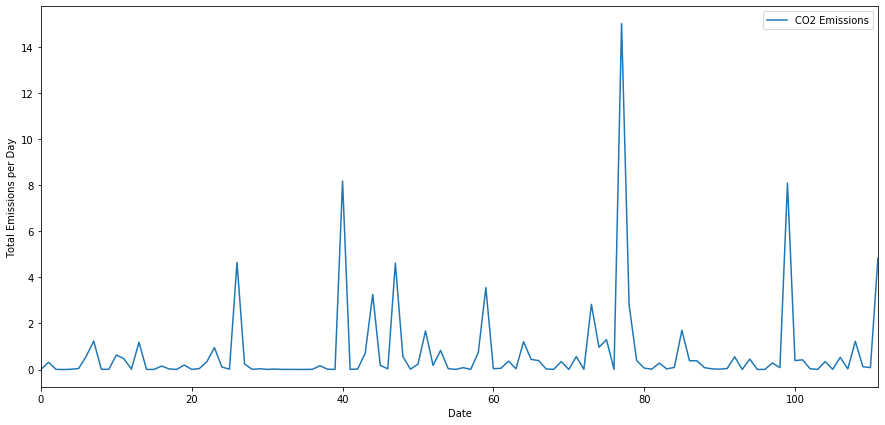

In [145]:
import matplotlib.pyplot as plt

# plotting CO2 emissions over time
plt.figure()
co2_per_day = orders.groupby(['Date'])['CO2 Emissions'].sum().reset_index()
co2_per_day.plot.line(figsize=(15,7))
plt.xlabel('Date')
plt.ylabel('Total Emissions per Day')